# Analisis de señales inerciales para la detección de fatiga en movimientos repetitivos

## Librerias utilizadas

In [1]:
import os
import sys
import pandas as pd
import tsfel
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from scipy.signal import butter, cheby1, cheby2, ellip, bessel, freqz, lfilter, medfilt, wiener, savgol_filter
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Cargar datos

In [2]:
lpmsb2_dfs = {}
baseline_lpmsb2_dfs = {}
mpu6050_dfs = {}
baseline_mpu6050_dfs = {}

list_dir = os.listdir("./Datos/LPMS-B2")
for file in list_dir:
    if file.endswith("_calibracion.csv"):
        baseline_lpmsb2_dfs[file[:-16]]= pd.read_csv("./Datos/LPMS-B2/" + file)
    else:
        lpmsb2_dfs[file[:-4]]= pd.read_csv("./Datos/LPMS-B2/" + file)

list_dir = os.listdir("./Datos/MPU6050/")
columnas = ["timestamp", "AccX", "AccY" , "AccZ", "GyroX", "GyroY", "GyroZ"]
for file in list_dir:
    if file.endswith("_calibracion.csv"):
        baseline_mpu6050_dfs[file[:-16]]= pd.read_csv("./Datos/MPU6050/" + file, names=columnas)
    else:
        mpu6050_dfs[file[:-4]]= pd.read_csv("./Datos/MPU6050/" + file, names=columnas)

## Analisis exploratorio

### Analisis en el dominio del tiempo

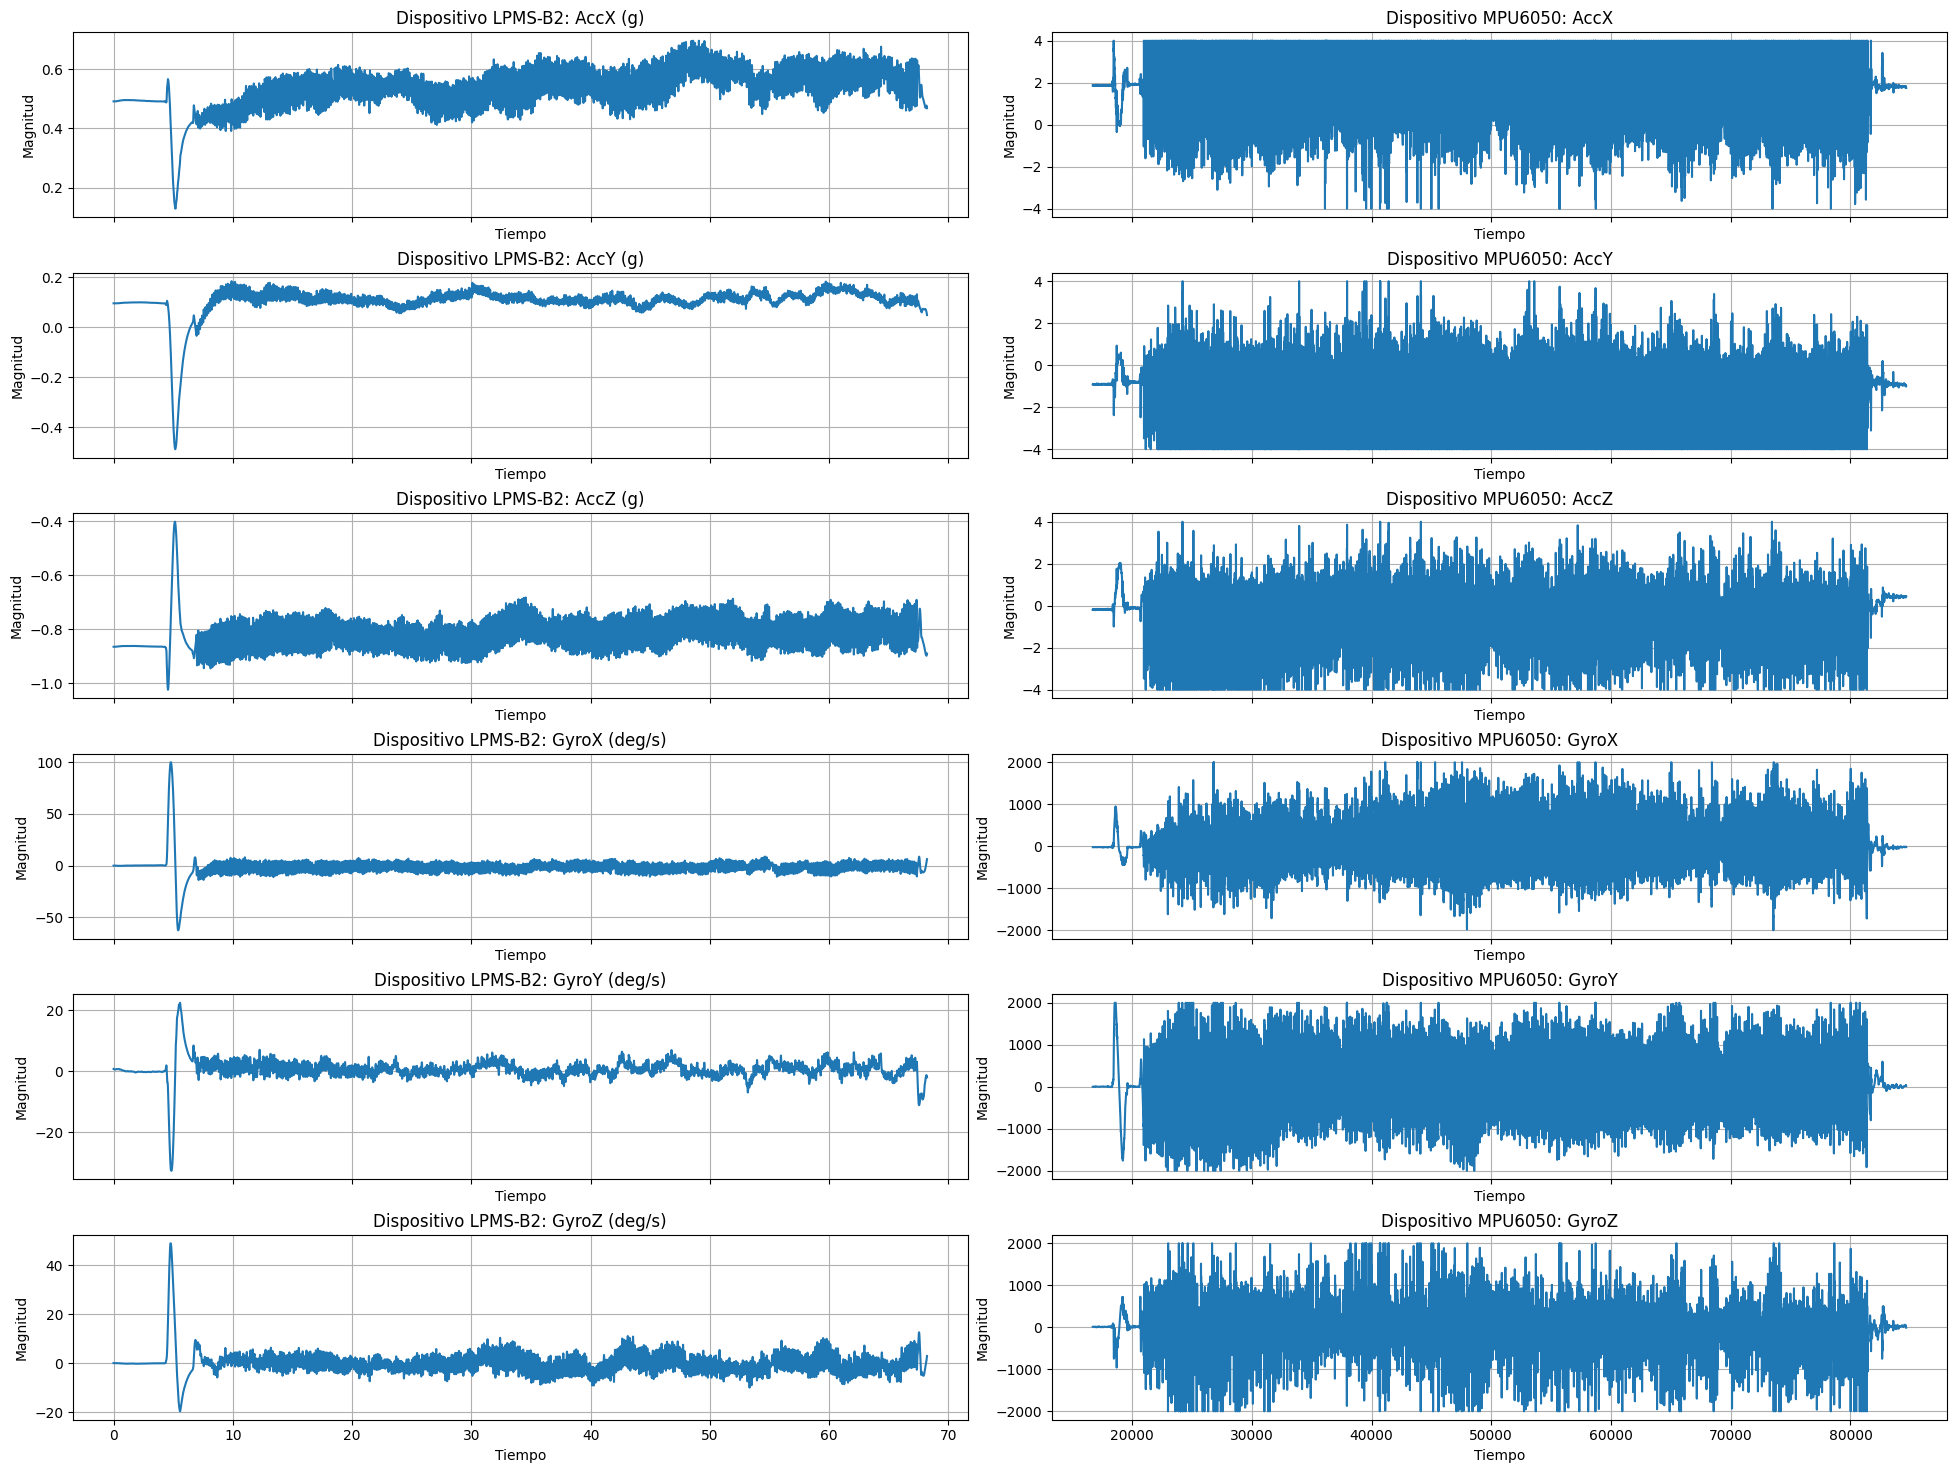

In [3]:
import matplotlib.pyplot as plt

# Configurar los nombres de las columnas y el sujeto
sujeto = "andres"
columns_lpmsb2 = lpmsb2_dfs[sujeto].columns[3:-17]
columns_mpu6050 = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]

# Asumiendo que el número de señales a graficar es el mismo para ambos dispositivos
num_signals = max(len(columns_lpmsb2), len(columns_mpu6050))

# Crear una figura y un conjunto de subgráficos con 2 columnas
fig, axs = plt.subplots(num_signals, 2, figsize=(20, 15), sharex='col')

# Ajusta el espacio entre los gráficos para evitar que los títulos se superpongan
fig.tight_layout(pad=3.0)

# Graficar los datos del dispositivo 1
for i, column in enumerate(columns_lpmsb2):
    axs[i, 0].plot(lpmsb2_dfs[sujeto][' TimeStamp (s)'], lpmsb2_dfs[sujeto][column], label=column.strip())
    axs[i, 0].set_title(f'Dispositivo LPMS-B2: {column.strip()}')
    axs[i, 0].set_xlabel("Tiempo")
    axs[i, 0].set_ylabel('Magnitud')
    axs[i, 0].grid(True)

# Graficar los datos del dispositivo 2
for i, column in enumerate(columns_mpu6050):
    axs[i, 1].plot(mpu6050_dfs[sujeto]["timestamp"], mpu6050_dfs[sujeto][column], label=column)
    axs[i, 1].set_title(f'Dispositivo MPU6050: {column}')
    axs[i, 1].set_xlabel("Tiempo")
    axs[i, 1].set_ylabel('Magnitud')
    axs[i, 1].grid(True)

plt.show()


### Analisis en el dominio de frecuencias

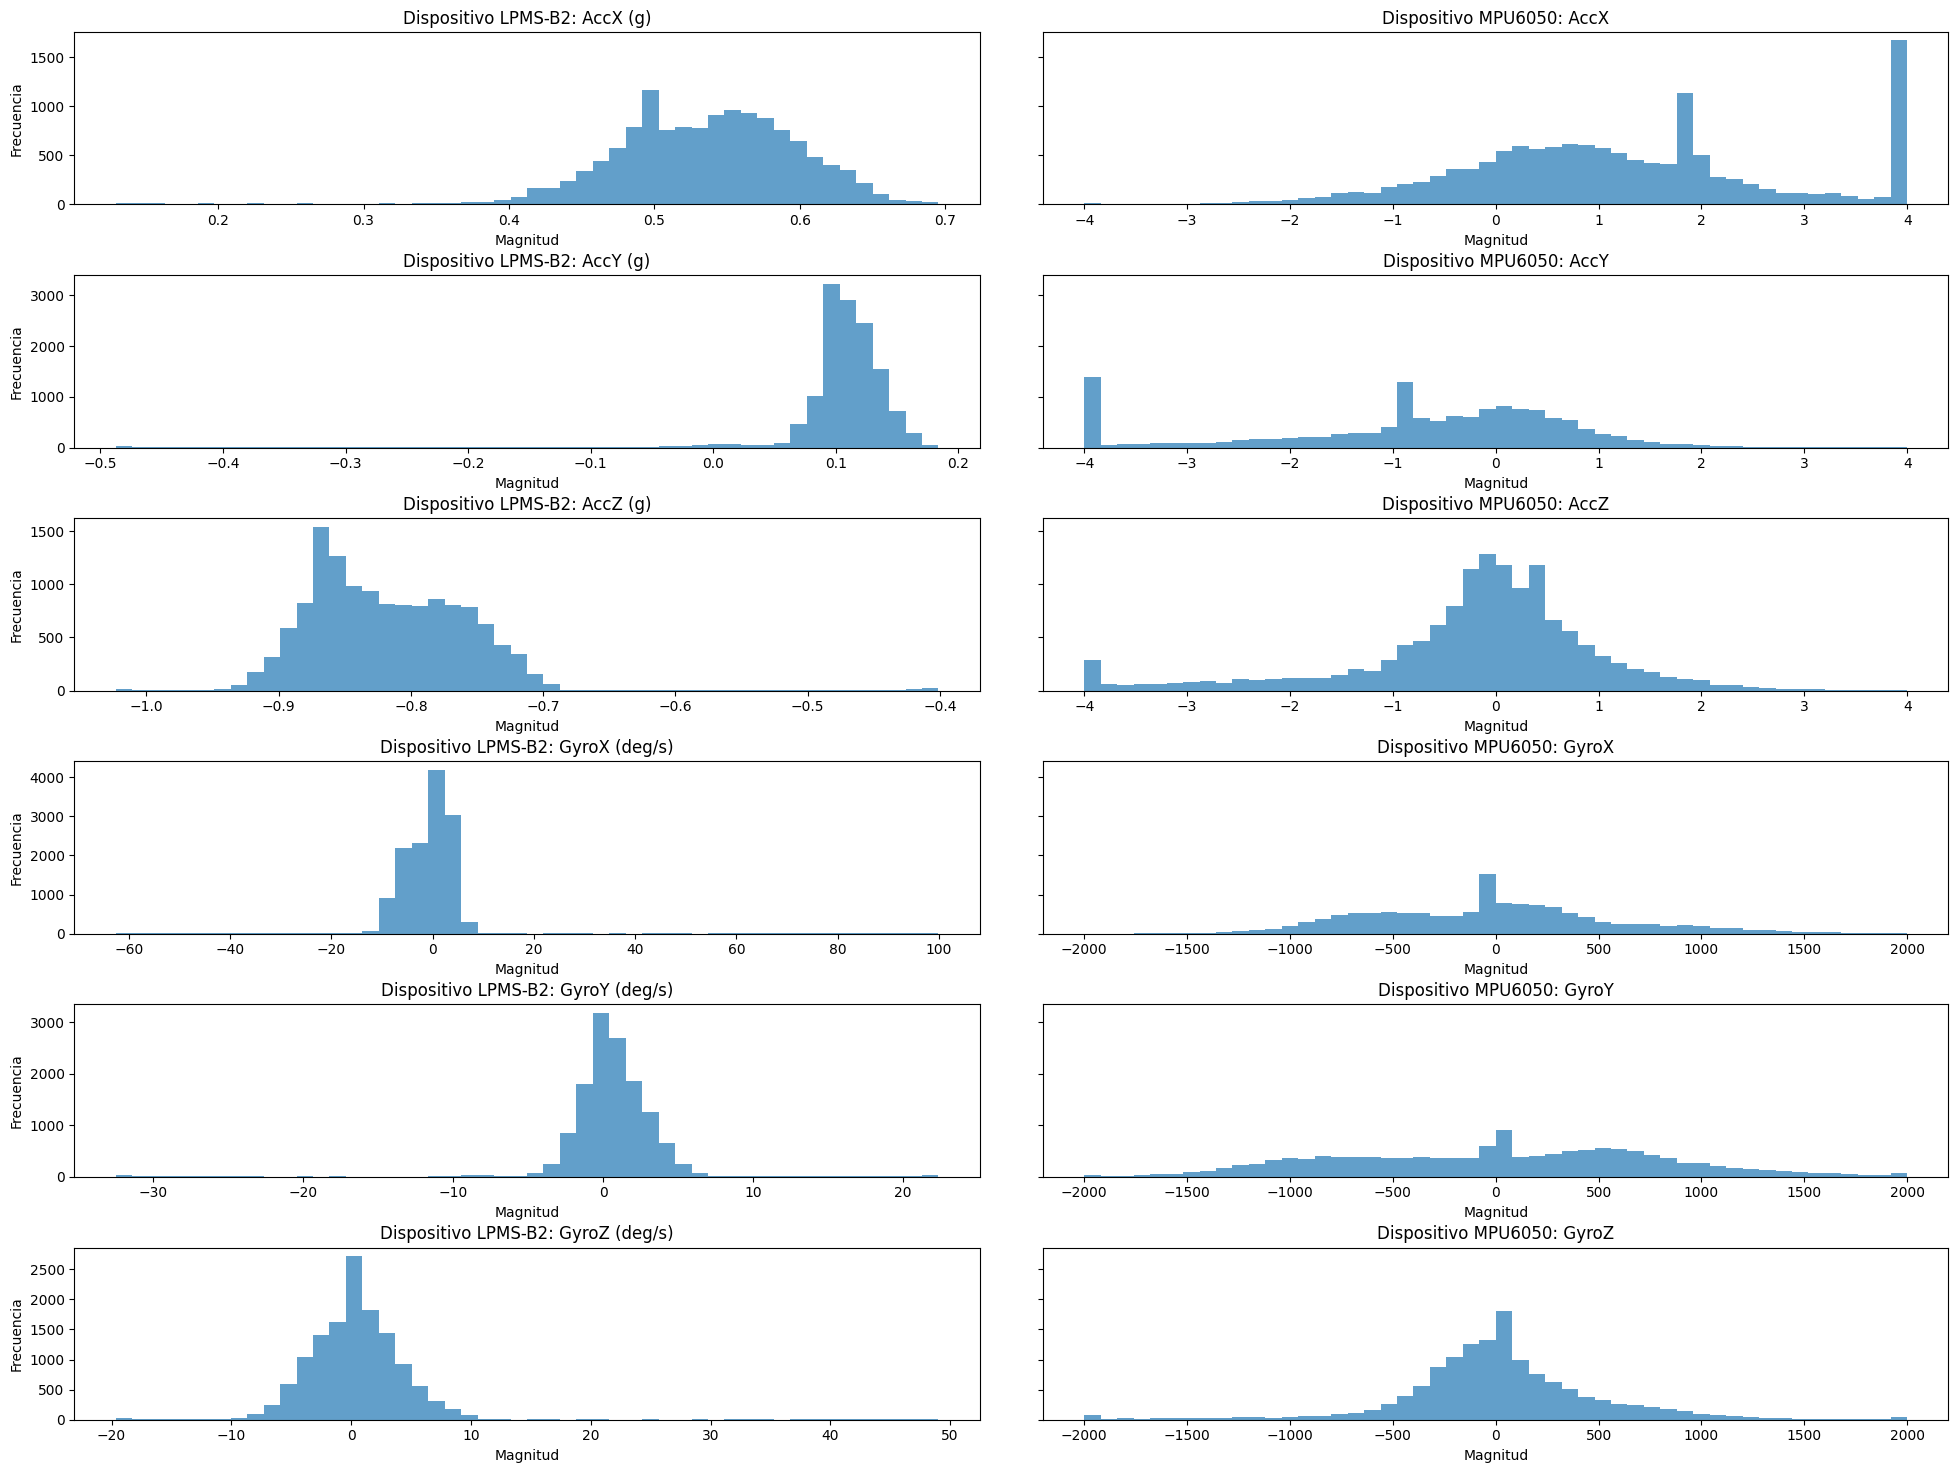

In [4]:
import matplotlib.pyplot as plt

# Configurar los nombres de las columnas y el sujeto
sujeto = "andres"
columns_lpmsb2 = lpmsb2_dfs[sujeto].columns[3:-17]
columns_mpu6050 = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]

# Asumiendo que el número de señales a graficar es el mismo para ambos dispositivos
num_signals = max(len(columns_lpmsb2), len(columns_mpu6050))

# Crear una figura y un conjunto de subgráficos con 2 columnas
fig, axs = plt.subplots(num_signals, 2, figsize=(20, 15), sharey='row')

# Ajustar el espacio entre los gráficos para evitar que los títulos se superpongan
fig.tight_layout(pad=3.0)

# Graficar los histogramas del dispositivo 1
for i, column in enumerate(columns_lpmsb2):
    axs[i, 0].hist(lpmsb2_dfs[sujeto][column], bins=50, alpha=0.7)
    axs[i, 0].set_title(f'Dispositivo LPMS-B2: {column.strip()}')
    axs[i, 0].set_xlabel('Magnitud')
    axs[i, 0].set_ylabel('Frecuencia')

# Graficar los histogramas del dispositivo 2
for i, column in enumerate(columns_mpu6050):
    axs[i, 1].hist(mpu6050_dfs[sujeto][column], bins=50, alpha=0.7)
    axs[i, 1].set_title(f'Dispositivo MPU6050: {column}')
    axs[i, 1].set_xlabel('Magnitud')
    # axs[i, 1].set_ylabel('Frecuencia')  # Comentado para evitar etiquetas redundantes en el eje Y

plt.show()


## Limpieza y Preprocesado de datos

#### Adaptar formato timestamp 

In [5]:
# Transformación del timestamp adecuandose al output del LPMS-B2
for sujeto in mpu6050_dfs:
    # Restar el primer valor de 'timestamp' a toda la columna para normalizar a 0
    mpu6050_dfs[sujeto]["timestamp"] -= mpu6050_dfs[sujeto]["timestamp"].iloc[0]
    baseline_mpu6050_dfs[sujeto]["timestamp"] -= baseline_mpu6050_dfs[sujeto]["timestamp"].iloc[0]
    # Convertir 'timestamp' de milisegundos a segundos
    mpu6050_dfs[sujeto]["timestamp"] = mpu6050_dfs[sujeto]["timestamp"] / 1000
    baseline_mpu6050_dfs[sujeto]["timestamp"] = baseline_mpu6050_dfs[sujeto]["timestamp"] / 1000

In [17]:
print(mpu6050_dfs["andres"]["timestamp"], lpmsb2_dfs["andres"][' TimeStamp (s)'])

0         0.000
1         0.005
2         0.010
3         0.015
4         0.020
          ...  
13583    67.917
13584    67.922
13585    67.927
13586    67.932
13587    67.937
Name: timestamp, Length: 13588, dtype: float64 0        -0.000
1         0.005
2         0.010
3         0.015
4         0.020
          ...  
13334    68.185
13335    68.190
13336    68.195
13337    68.200
13338    68.205
Name:  TimeStamp (s), Length: 13339, dtype: float64


#### Obtener la magnitud total de las señales

### Eliminación de ruido en las señales

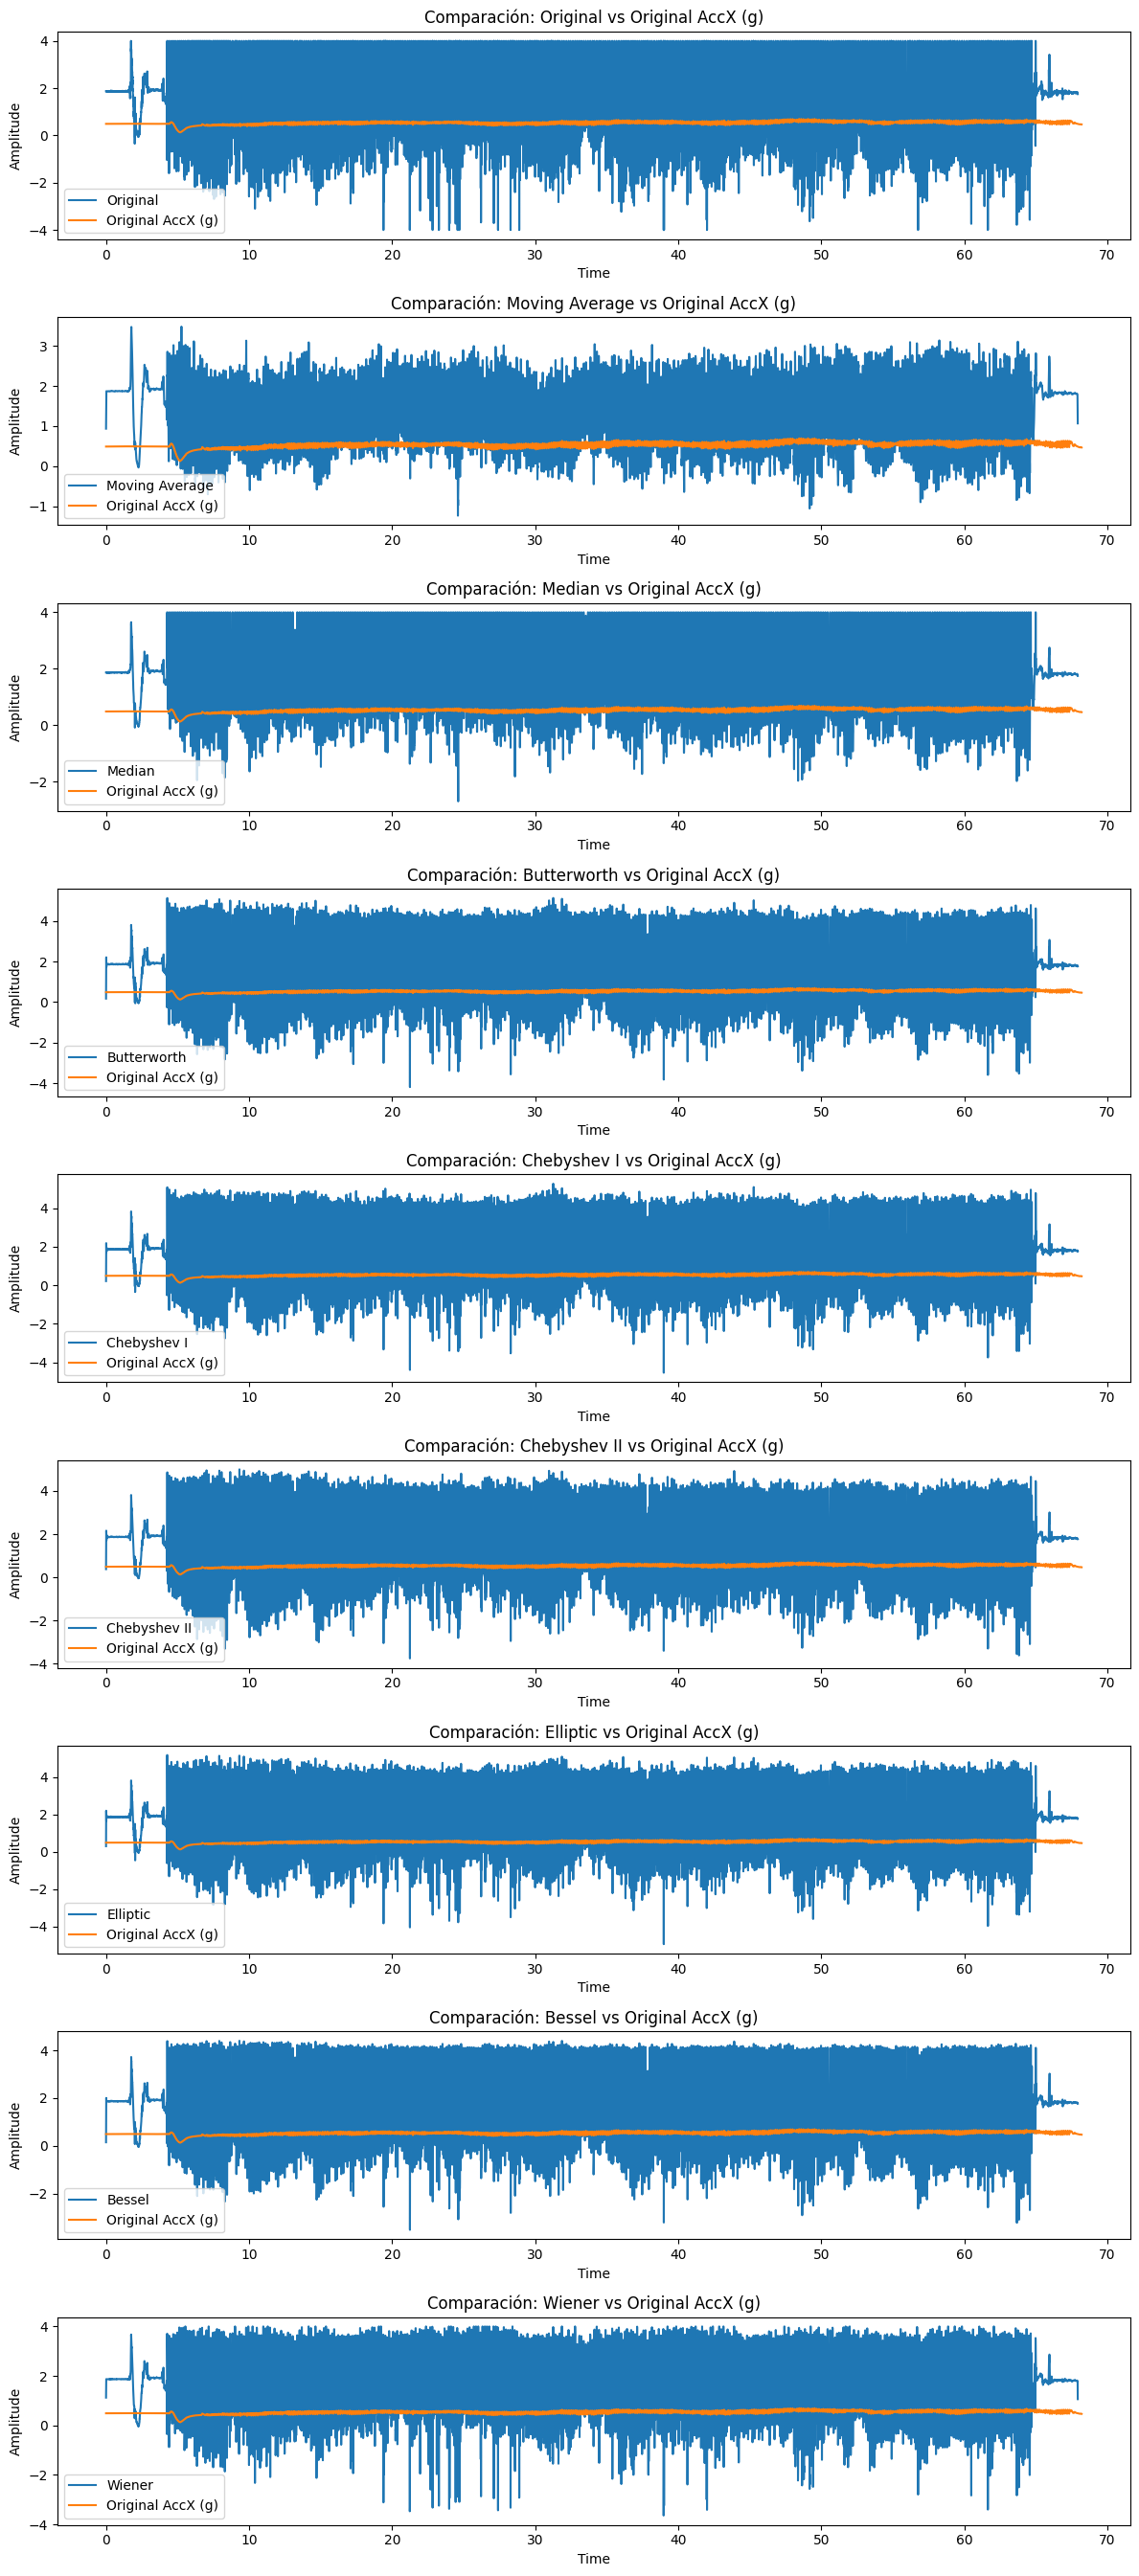

In [18]:
import numpy as np
import pandas as pd
from scipy.signal import butter, cheby1, cheby2, ellip, bessel, lfilter, medfilt, wiener
import matplotlib.pyplot as plt

# Asumiendo que tienes un DataFrame 'df' con una columna 'Signal' y una columna 'Time'
# Reemplaza 'mpu6050_dfs' y 'AccX' con el nombre de tu DataFrame y columna respectivamente
# df = pd.DataFrame({'Time': your_time_data, 'Signal': your_signal_data})


# Parámetros para diseño de filtros
fs = 100  # Frecuencia de muestreo en Hz
cutoff = fs / 4  # Frecuencia de corte
order = 4  # Orden del filtro
nyq = 0.5 * fs  # Frecuencia de Nyquist
normal_cutoff = cutoff / nyq  # Frecuencia de corte normalizada

# Filtro de media móvil
def moving_average_filter(data, window_size=10):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Filtro de mediana
def median_filter(data, kernel_size=5):
    return medfilt(data, kernel_size)

# Filtro de Butterworth
def butterworth_filter(data):
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, data)

# Filtro de Chebyshev Tipo I
def chebyshev1_filter(data):
    b, a = cheby1(order, 0.05, normal_cutoff)
    return lfilter(b, a, data)

# Filtro de Chebyshev Tipo II
def chebyshev2_filter(data):
    b, a = cheby2(order, 20, normal_cutoff)
    return lfilter(b, a, data)

# Filtro elíptico
def elliptic_filter(data):
    b, a = ellip(order, 0.01, 100, normal_cutoff)
    return lfilter(b, a, data)

# Filtro Bessel
def bessel_filter(data):
    b, a = bessel(order, normal_cutoff, btype='low', analog=False, norm='phase')
    return lfilter(b, a, data)

# Filtro Wiener
def wiener_filter(data, mysize=5):
    return wiener(data, mysize)

# Obtiene la señal a filtrar
signal = mpu6050_dfs["andres"]["AccX"].values

# Aplicar filtros
mov_avg_signal = moving_average_filter(signal)
median_signal = median_filter(signal)
butter_signal = butterworth_filter(signal)
cheby1_signal = chebyshev1_filter(signal)
cheby2_signal = chebyshev2_filter(signal)
ellip_signal = elliptic_filter(signal)
bessel_signal = bessel_filter(signal)
wiener_signal = wiener_filter(signal)

# Crear un diccionario con todas las señales
signals = {
    "Original": signal,
    "Moving Average": mov_avg_signal,
    "Median": median_signal,
    "Butterworth": butter_signal,
    "Chebyshev I": cheby1_signal,
    "Chebyshev II": cheby2_signal,
    "Elliptic": ellip_signal,
    "Bessel": bessel_signal,
    "Wiener": wiener_signal,
}

# Graficar las señales
plt.figure(figsize=(12, len(signals) * 3))  # Ajusta el tamaño de la figura según la cantidad de señales

# Recorre todas las señales filtradas y grafícalas junto con la señal original 'AccX (g)'
for i, (label, filtered_signal) in enumerate(signals.items()):
    plt.subplot(len(signals), 1, i+1)
    
    # Grafica la señal filtrada
    plt.plot(mpu6050_dfs["andres"]["timestamp"], filtered_signal, label=label)
    
    # Grafica la señal original 'AccX (g)' en el mismo subplot para comparación
    # Asegúrate de que el rango de tiempo coincida con el de la señal filtrada
    plt.plot(lpmsb2_dfs["andres"][' TimeStamp (s)'], lpmsb2_dfs["andres"][" AccX (g)"], label="Original AccX (g)", linestyle='-')
    plt.title(f"Comparación: {label} vs Original AccX (g)")
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.show()


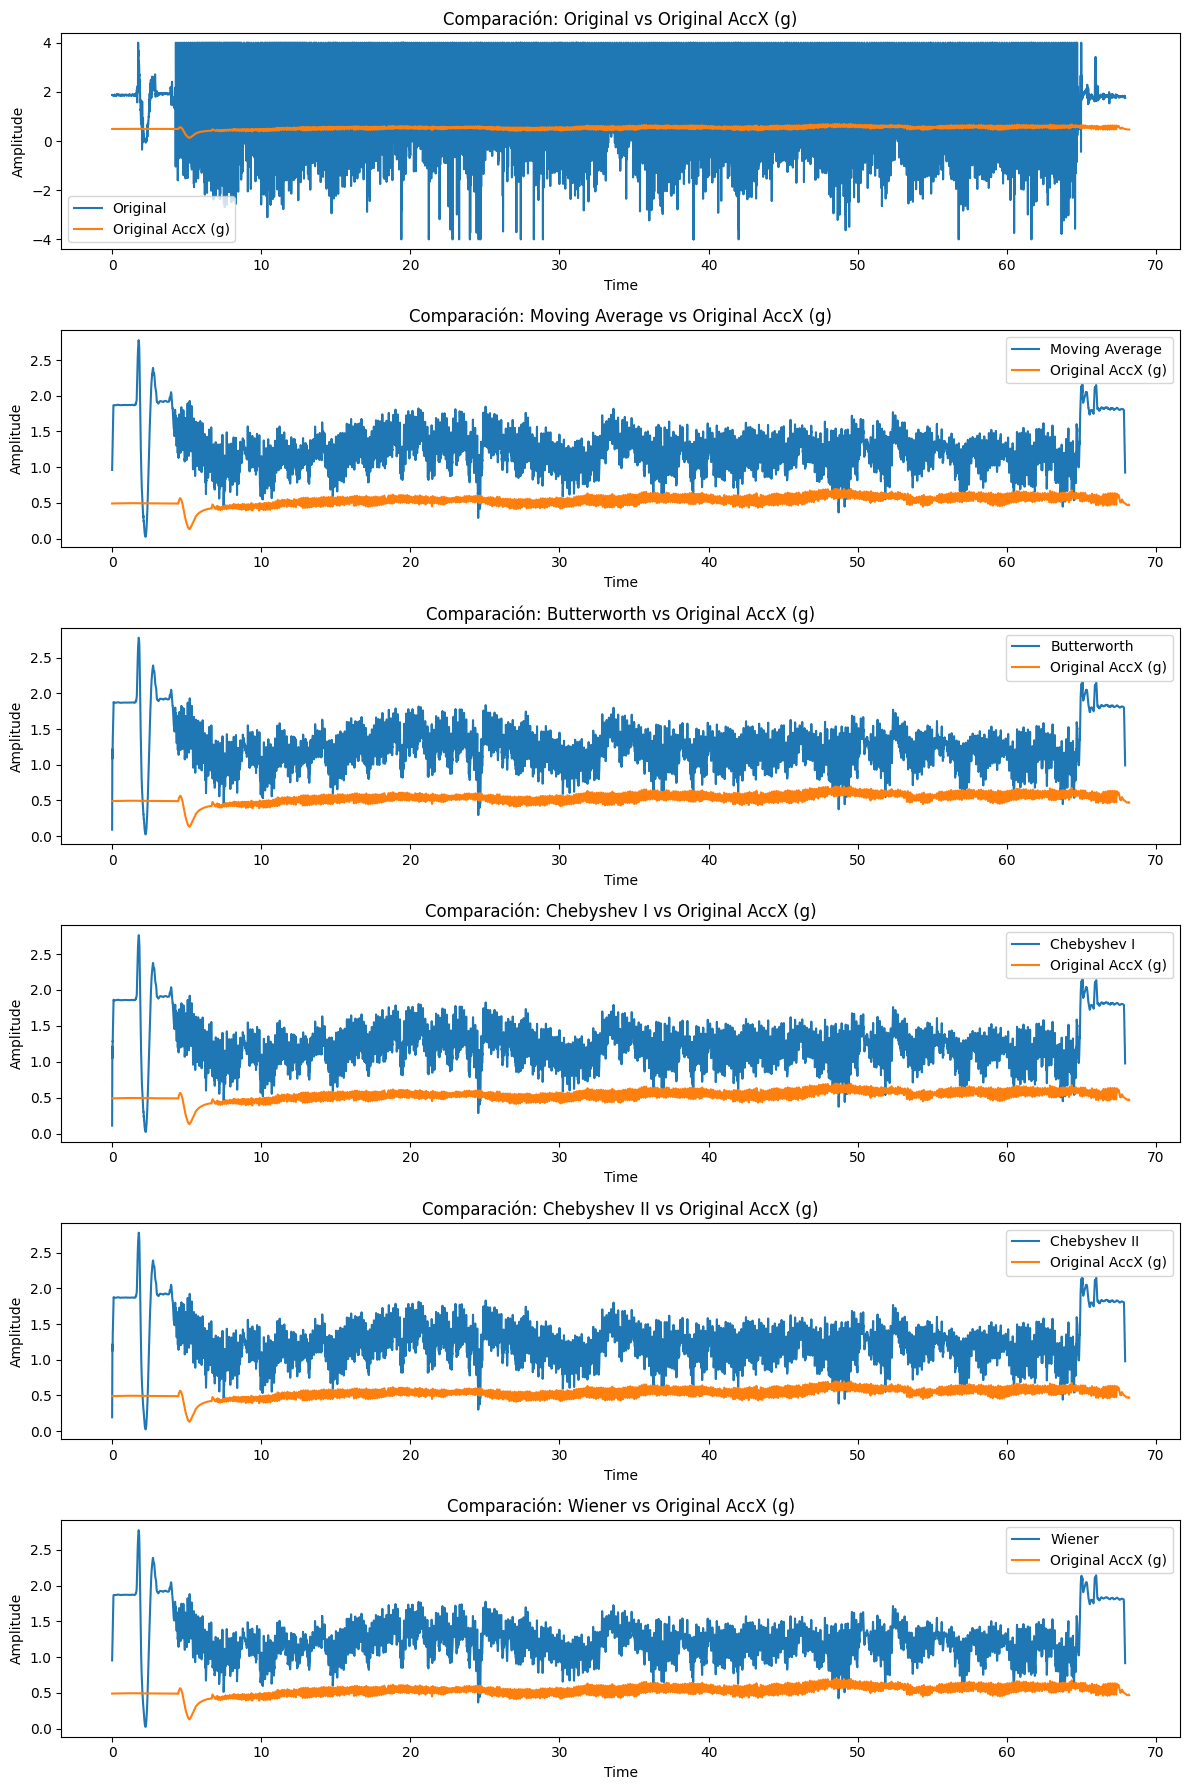

In [25]:
# Obtiene la señal a filtrar
signal = mpu6050_dfs["andres"]["AccX"].values

# Aplicar filtros
mov_avg_signal = moving_average_filter(signal, window_size=35)
butter_signal = butterworth_filter(mov_avg_signal)
cheby1_signal = chebyshev1_filter(mov_avg_signal)
cheby2_signal = chebyshev2_filter(mov_avg_signal)
wiener_signal = wiener_filter(mov_avg_signal)

# Crear un diccionario con todas las señales
signals = {
    "Original": signal,
    "Moving Average": mov_avg_signal,
    "Butterworth": butter_signal,
    "Chebyshev I": cheby1_signal,
    "Chebyshev II": cheby2_signal,
    "Wiener": wiener_signal,
}

# Graficar las señales
plt.figure(figsize=(12, len(signals) * 3))  # Ajusta el tamaño de la figura según la cantidad de señales

# Recorre todas las señales filtradas y grafícalas junto con la señal original 'AccX (g)'
for i, (label, filtered_signal) in enumerate(signals.items()):
    plt.subplot(len(signals), 1, i+1)
    
    # Grafica la señal filtrada
    plt.plot(mpu6050_dfs["andres"]["timestamp"], filtered_signal, label=label)
    
    # Grafica la señal original 'AccX (g)' en el mismo subplot para comparación
    # Asegúrate de que el rango de tiempo coincida con el de la señal filtrada
    plt.plot(lpmsb2_dfs["andres"][' TimeStamp (s)'], lpmsb2_dfs["andres"][" AccX (g)"], label="Original AccX (g)", linestyle='-')
    plt.title(f"Comparación: {label} vs Original AccX (g)")
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.show()

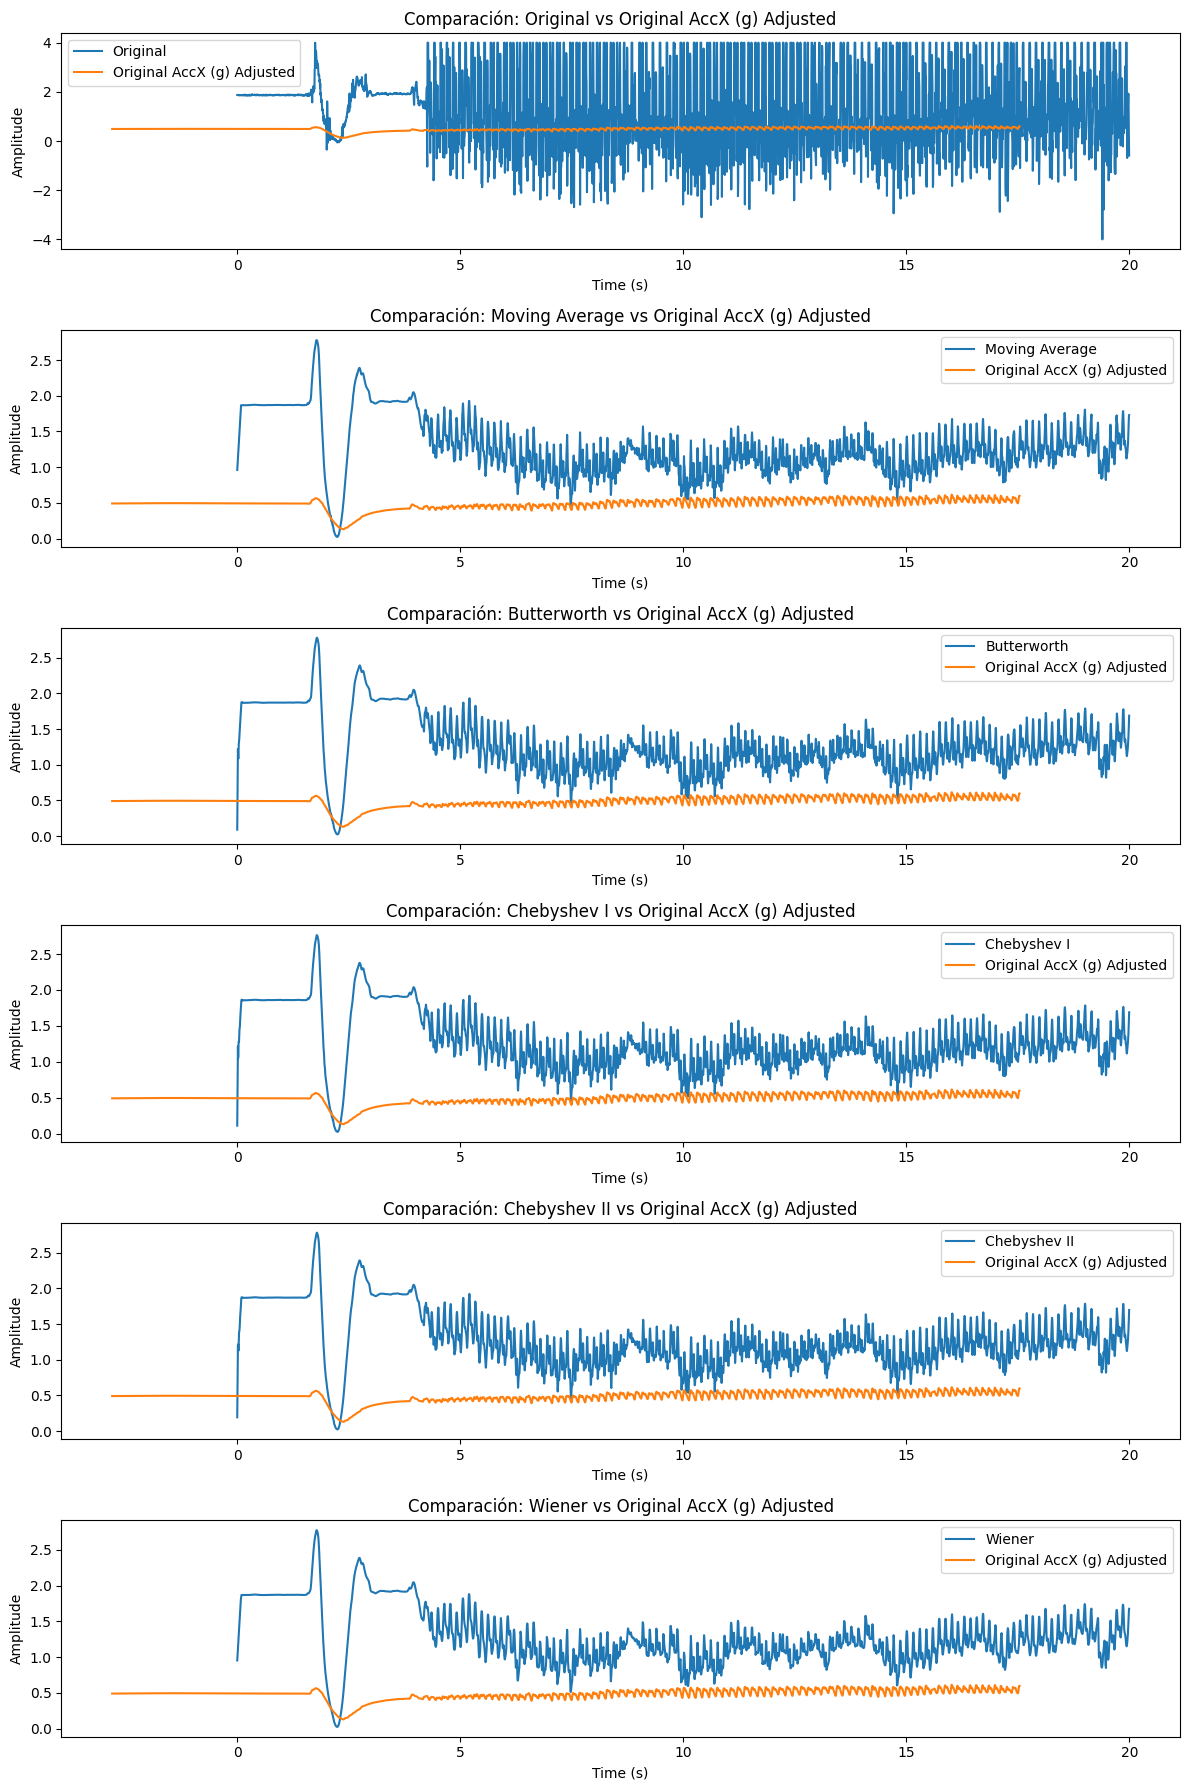

In [33]:
# Suponiendo que lpmsb2_dfs es tu DataFrame y ya está cargado correctamente
lpmsb2_dfs["andres"]['Adjusted TimeStamp (s)'] = lpmsb2_dfs["andres"][' TimeStamp (s)'] - 2.805  # Retrasamos 3 segundos los timestamps de LPMS-B2

# Suponiendo que 'signals' contiene las señales filtradas y 'mpu6050_dfs' contiene los datos de MPU6050
# También asumiremos que las señales en 'signals' ya están sincronizadas con los timestamps de 'mpu6050_dfs'

# Definir la ventana de tiempo para graficar
start_time = 0  # comienzo de la ventana en segundos
end_time = 20    # fin de la ventana en segundos
sampling_rate = 200  # Frecuencia de muestreo en Hz
start_index = int(start_time * sampling_rate)
end_index = int(end_time * sampling_rate)

# Graficar las señales filtradas y la señal original con el timestamp ajustado
plt.figure(figsize=(12, len(signals) * 3))  # Ajusta el tamaño de la figura según la cantidad de señales

# Recorremos cada señal filtrada y la graficamos junto con la señal original ajustada
for i, (label, filtered_signal) in enumerate(signals.items()):
    plt.subplot(len(signals), 1, i + 1)
    
    # Graficamos la señal filtrada
    plt.plot(mpu6050_dfs["andres"]["timestamp"][start_index:end_index],
             filtered_signal[start_index:end_index], label=label)
    
    # Graficamos la señal original 'AccX (g)' con el timestamp ajustado para comparación
    plt.plot(lpmsb2_dfs["andres"]['Adjusted TimeStamp (s)'][start_index:end_index],
             lpmsb2_dfs["andres"][" AccX (g)"][start_index:end_index],
             label="Original AccX (g) Adjusted", linestyle='-')
    
    plt.title(f"Comparación: {label} vs Original AccX (g) Adjusted")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.show()


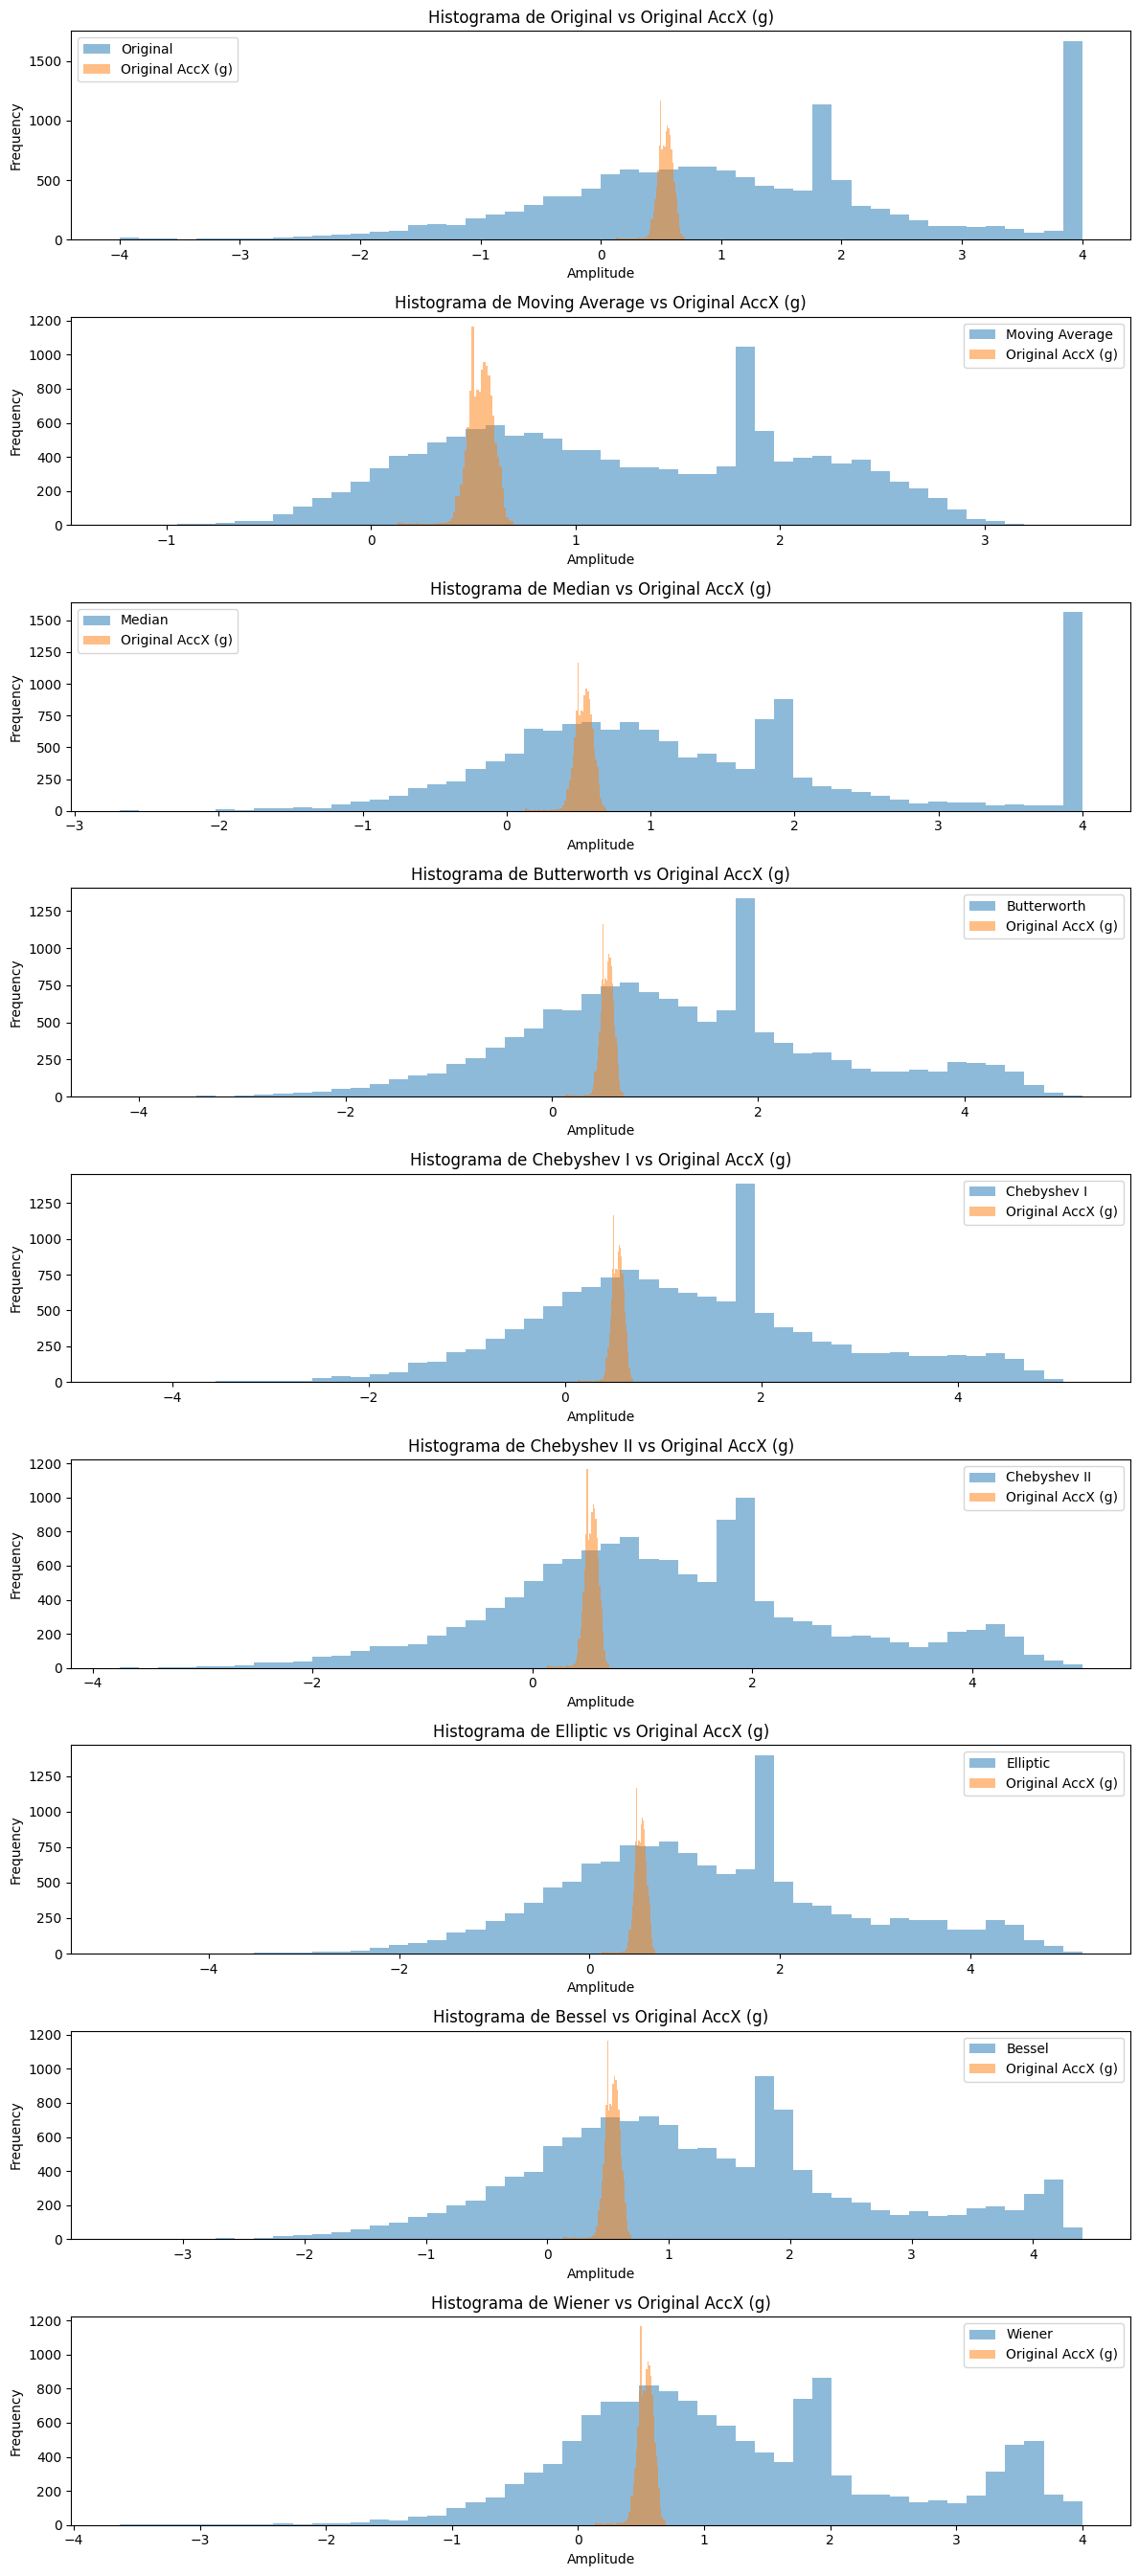

In [19]:
plt.figure(figsize=(12, len(signals) * 3))  # Ajusta el tamaño de la figura según la cantidad de señales

# Recorre todas las señales filtradas y grafícalas como histogramas
for i, (label, filtered_signal) in enumerate(signals.items()):
    plt.subplot(len(signals), 1, i+1)
    
    # Grafica el histograma de la señal filtrada
    plt.hist(filtered_signal, bins=50, alpha=0.5, label=label)
    
    # Grafica el histograma de la señal original 'AccX (g)' para comparación
    plt.hist(lpmsb2_dfs["andres"][" AccX (g)"], bins=50, alpha=0.5, label="Original AccX (g)")
    
    plt.title(f"Histograma de {label} vs Original AccX (g)")
    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


## Aproach Personalizado

### Extracción de caracteristicas

### Selección de atributos

## Aproach Generalizado

### Extracción de caracteristicas

### Selección de atributos

## Validación Cruzada

## Entrenamiento

## Validación